## Import the Datasets and the libraries

### Import the datasets

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random 

%matplotlib inline

SEED = 2147483647

# read all the names in a python list
with open(file="datasets/names.txt", mode="r") as namesTxt: 
    # names = [line[:-1] for line in namesTxt.readlines()]
    names = namesTxt.read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

### Build the datasets

In [2]:
# create the encoder for the letters
chars = ["."] + sorted(list(set("".join(names)))) 
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}
vocab_size = len(stoi)

# define the block size of the model
block_size = 3 # context length: how many characters to we consider to predict the next one

# helper function to encode the datasets
def buildDatasets(words):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        for ch in word + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    return (torch.tensor(X),torch.tensor(Y))

# shuffle the order of the names
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

# build the datasets
xtrain, ytrain = buildDatasets(names[:n1]) # 80%
xtest, ytest = buildDatasets(names[n1:n2]) # 10%
xdev, ydev = buildDatasets(names[n2:]) # 10 %

#### Create MLP

In [3]:
# define the parameters of the MLP
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of hidden layers
g = torch.Generator().manual_seed(SEED) # the Generator with a seed, for reproductibility
emb_T = torch.randn(size = (vocab_size, n_embd), generator = g, requires_grad= True) # Embedding the inputs in higher dimension
w1 = torch.randn(size=(n_embd * block_size, n_hidden), generator = g, requires_grad= True) # weights of the first layer
b1 = torch.randn(size=(n_hidden,), generator=g, requires_grad= True) # biaias of the first layer
w2 = torch.randn(size=(n_hidden, vocab_size), generator=g, requires_grad= True) # weight of the second layer
b2 = torch.randn(size=(vocab_size,), generator=g, requires_grad= True) # biais of the second layer
parameters = [emb_T, w1, b1, w2, b2]
print(f"Number of parameters of the MLP = {sum(p.nelement() for p in parameters)}")

Number of parameters of the MLP = 11897


#### Train MLP

In [12]:
# training parameters
max_path = 200000
batch_size = 32
lossi = []
xtrain_len = xtrain.shape[0]

# forward pass
for i in range(max_path):
# for i in range(1):

	# prepare the data of the training batch
	ix = torch.randint(low = 0, high=xtrain_len, size=(batch_size,), generator=g)
	xbatch, ybatch = xtrain[ix], ytrain[ix]

	# forward pass
	emb = emb_T[xbatch] # embed the characters into tensor
	embcat = emb.view(emb.shape[0], -1) # concatenate the tensors
	hpreact = embcat @ w1 + b1 # pass through the first hidden layer
	h = torch.tanh(hpreact) # activation function of the first layer
	logits = h @ w2 + b2 # output layer
	loss = F.cross_entropy(logits, ybatch) # loss function of this batch

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update the weights
	lr = 0.1 if i<10000 else 0.01
	# lr = 0.05 if i<10000 else 0.01
	for p in parameters:
		p.data += - lr * p.grad
  
	# print the results once in a while
	if i % 10000 == 0:
		print(f"The loss of the batch Nr.{i} = {loss.item():.4f}")
	lossi.append(loss.log10().item())


The loss of the batch Nr.0 = 2.1669
The loss of the batch Nr.10000 = 2.4308
The loss of the batch Nr.20000 = 2.2901
The loss of the batch Nr.30000 = 2.1796
The loss of the batch Nr.40000 = 2.1516
The loss of the batch Nr.50000 = 1.9200
The loss of the batch Nr.60000 = 2.0837
The loss of the batch Nr.70000 = 2.4782
The loss of the batch Nr.80000 = 1.8185
The loss of the batch Nr.90000 = 2.2332
The loss of the batch Nr.100000 = 2.2782
The loss of the batch Nr.110000 = 2.3033
The loss of the batch Nr.120000 = 2.1753
The loss of the batch Nr.130000 = 1.8456
The loss of the batch Nr.140000 = 2.0546
The loss of the batch Nr.150000 = 2.3757
The loss of the batch Nr.160000 = 2.1555
The loss of the batch Nr.170000 = 2.5299
The loss of the batch Nr.180000 = 2.2288
The loss of the batch Nr.190000 = 2.2398


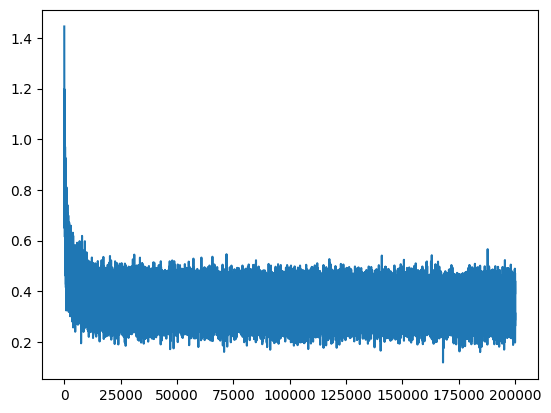

In [5]:
plt.plot(lossi)

In [13]:
emb = emb_T[xtrain] # embed the characters into tensor
embcat = emb.view(emb.shape[0], -1) # concatenate the tensors
hpreact = embcat @ w1 + b1 # pass through the first hidden layer
h = torch.tanh(hpreact) # activation function of the first layer
logits = h @ w2 + b2 # output layer
loss = F.cross_entropy(logits, ytrain) # loss function of this batch
loss

tensor(2.1633, grad_fn=<NllLossBackward0>)

In [14]:
emb = emb_T[xdev] # embed the characters into tensor
embcat = emb.view(emb.shape[0], -1) # concatenate the tensors
hpreact = embcat @ w1 + b1 # pass through the first hidden layer
h = torch.tanh(hpreact) # activation function of the first layer
logits = h @ w2 + b2 # output layer
loss = F.cross_entropy(logits, ydev) # loss function of this batch
loss

tensor(2.1933, grad_fn=<NllLossBackward0>)